In [1]:
import pandas as pd
import pandas_profiling
import shapefile
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
import pylab as plot
import numpy as np
import pickle

from shapely.geometry import shape
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.geocoders import OpenMapQuest
from geopy.geocoders import Bing
from shapely.geometry import Point

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

I am pulling the medicare inpatient Charge Data for 2015, per the source document:  
"The Inpatient Payment Public Use File includes information on utilization, payment (total payment and Medicare payment), and hospital-specific charges for the more than 3,000 U.S. hospitals that receive Medicare Inpatient Prospective Payment System (IPPS) payments.'

In [2]:
medicare_df = pd.read_csv('link', 
                       encoding='utf-8', low_memory=False)


In [3]:
medicare_df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,"$32,963.07","$5,777.24","$4,763.73"
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,"$15,131.85","$5,787.57","$4,976.71"
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,"$37,560.37","$5,434.95","$4,453.79"
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,"$13,998.28","$5,417.56","$4,129.16"
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,"$31,633.27","$5,658.33","$4,851.44"


The relevent data here are total discharges, average covered charges, average total payments, and average medicare payments. I want to map these data as a visual representation so I am going to pull shapefiles of U.S Counties from https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html and map the medicare data on top of it. 

In [4]:
lcp_dir = 'link'
myshp = open(lcp_dir + 'cb_2016_us_county_500k.shp', "rb")
mydbf = open(lcp_dir + 'cb_2016_us_county_500k.dbf', "rb")
r = shapefile.Reader(shp=myshp, dbf=mydbf)

In [5]:
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  
    

In [6]:
proj4_string = '+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs'

In [7]:
gdf_US = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)

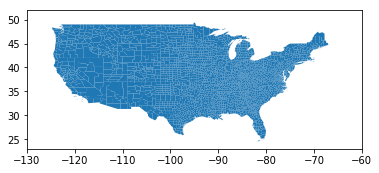

In [8]:
ax1 = gdf_US.plot()
ax1.set_xlim([-130, -60])
ax1.set_ylim([23, 52])
plt.rcParams["figure.figsize"] = [30,25]

Now that we have a geoframe for the US shapefile, we can convert the zip code information from medicare_df into latitude and longitude via the GeoPy package. I acutally run into a bit of issue with using the google API since there is a limit of 2500 requests per day. So instead of running through the entire df, I am going to pull the zip code of the hosiptals and use that to build a dictionary of hospital: Long, Lat 

In [9]:
len(medicare_df['Provider Zip Code'].unique())

3053

In [10]:
hospital_zip = medicare_df['Provider Zip Code'].unique()
hospital_zip = [str(i) for i in hospital_zip]
hospital_zip_split = np.array_split(hospital_zip, 5)

In [11]:
#geolocator = OpenMapQuest(api_key = 'key')
geolocator_bing = Bing('key')

In [95]:
def longlat_pull(zip_list):
    hospital_zip_dict = {}
    for i in zip_list: 
        location = geolocator_bing.geocode(i) 
        if location is not None:
            hospital_zip_dict[i] = (location.longitude, location.latitude)
        else: 
            hospital_zip_dict[i] = None 
    return hospital_zip_dict

In [96]:
part1_dict = longlat_pull(hospital_zip_split[0])

In [99]:
part2_dict = longlat_pull(hospital_zip_split[1])

In [102]:
part3_dict = longlat_pull(hospital_zip_split[2])

In [103]:
part4_dict = longlat_pull(hospital_zip_split[3])

In [108]:
part5_dict = longlat_pull(hospital_zip_split[4])
#Had a bit of issue of pulling in everthing at once, so I divvied up the ZIP codes into 5 parts. 

In [123]:
merged_5_part = {**part1_dict, **part2_dict,**part3_dict, **part4_dict, **part5_dict}

In [112]:
pickle.dump(merged_5_part, open("all_long_lat", "wb" ))

In [145]:
medicare_df['long_lat'] = medicare_df['Provider Zip Code'].apply(lambda x: merged_5_part[str(x)])

In [146]:
medicare_df['long_lat'].isnull().sum()

274

In [134]:
nans = lambda medicare_df: medicare_df[medicare_df.isnull().any(axis=1)]
na_lat_long = nans(medicare_df)
na_lat_long['Provider Name'].value_counts()


BAYSTATE MEDICAL CENTER       98
NORTH SHORE MEDICAL CENTER    93
RARITAN BAY MEDICAL CENTER    83
Name: Provider Name, dtype: int64

Three of the zipcode weren't able to find matches, I am going to use addresses and see if there is better luck there. 

In [151]:
left_over = na_lat_long['Provider Street Address'].unique()
left_over_dict = longlat_pull(left_over)
left_over_dict

{'530 NEW BRUNSWICK AVE': (-79.41058, 43.67353),
 '759 CHESTNUT STREET': (-73.8624644781137, 40.8727927670831),
 '81 HIGHLAND AVENUE': (-71.0834833167858, 42.49871916188)}

In [164]:
medicare_df['long_lat'] = medicare_df['long_lat'].fillna(medicare_df['Provider Street Address'].map(left_over_dict))

In [165]:
medicare_df['long_lat'].isnull().sum()

0

In [166]:
medicare_geometry = [Point(xy) for xy in medicare_df['long_lat']]

In [167]:
gdf_medicare = gpd.GeoDataFrame(medicare_df, geometry = medicare_geometry, crs = proj4_string)

In [169]:
gdf_medicare.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,long_lat,geometry
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,"$32,963.07","$5,777.24","$4,763.73","(-85.3928604125977, 31.2167854309082)",POINT (-85.3928604125977 31.2167854309082)
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,"$15,131.85","$5,787.57","$4,976.71","(-86.3727798461914, 34.1399955749512)",POINT (-86.37277984619141 34.1399955749512)
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,"$37,560.37","$5,434.95","$4,453.79","(-87.6751022338867, 34.8017730712891)",POINT (-87.6751022338867 34.8017730712891)
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,"$13,998.28","$5,417.56","$4,129.16","(-86.636100769043, 33.6505241394043)",POINT (-86.636100769043 33.6505241394043)
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,"$31,633.27","$5,658.33","$4,851.44","(-86.8290939331055, 33.2154388427734)",POINT (-86.8290939331055 33.2154388427734)


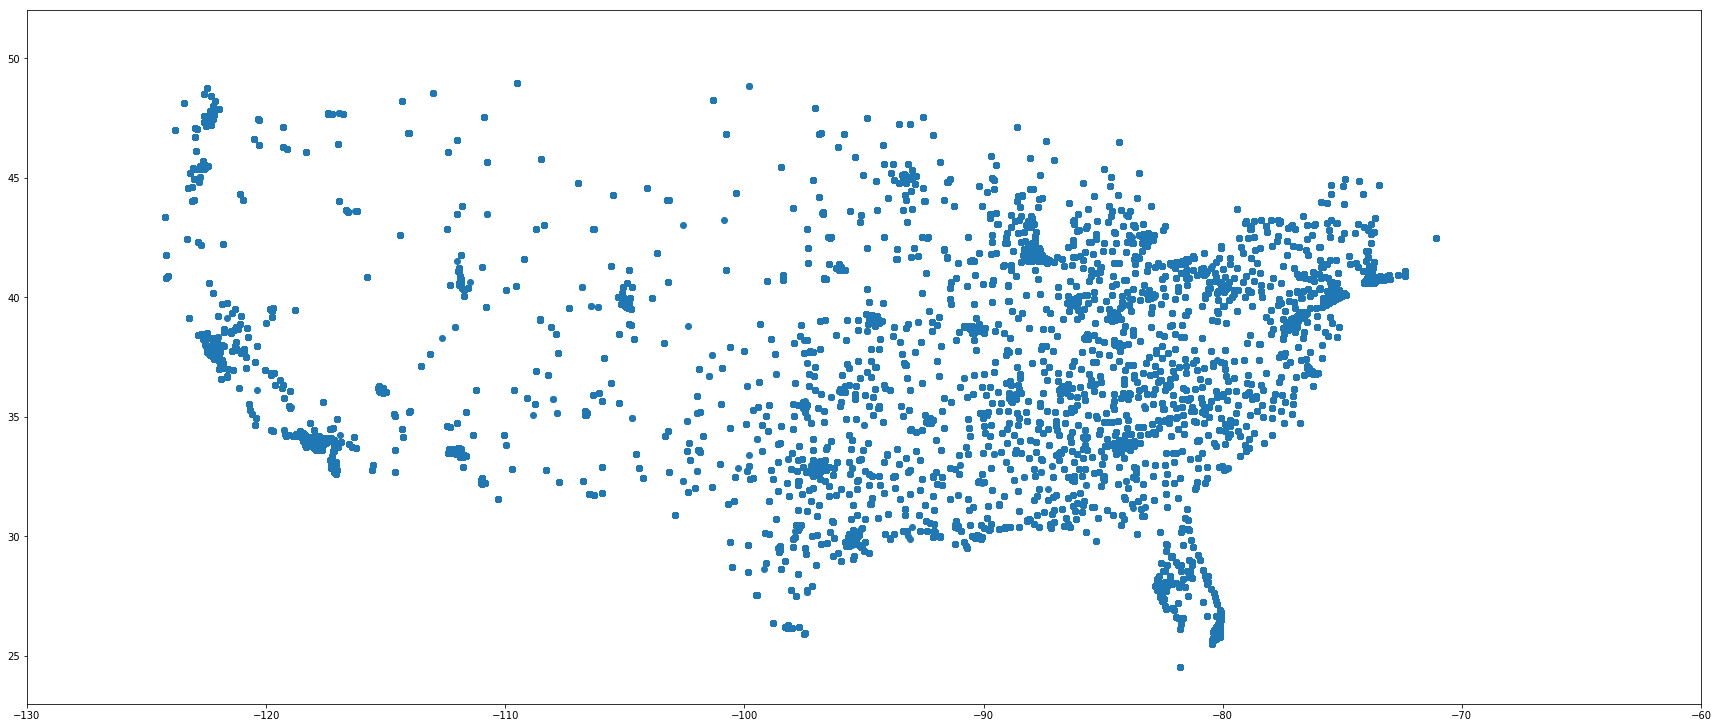

In [180]:
ax2 = gdf_medicare.plot()
ax2.set_xlim([-130, -60])
ax2.set_ylim([23, 52])
plt.rcParams["figure.figsize"] = [30,25]

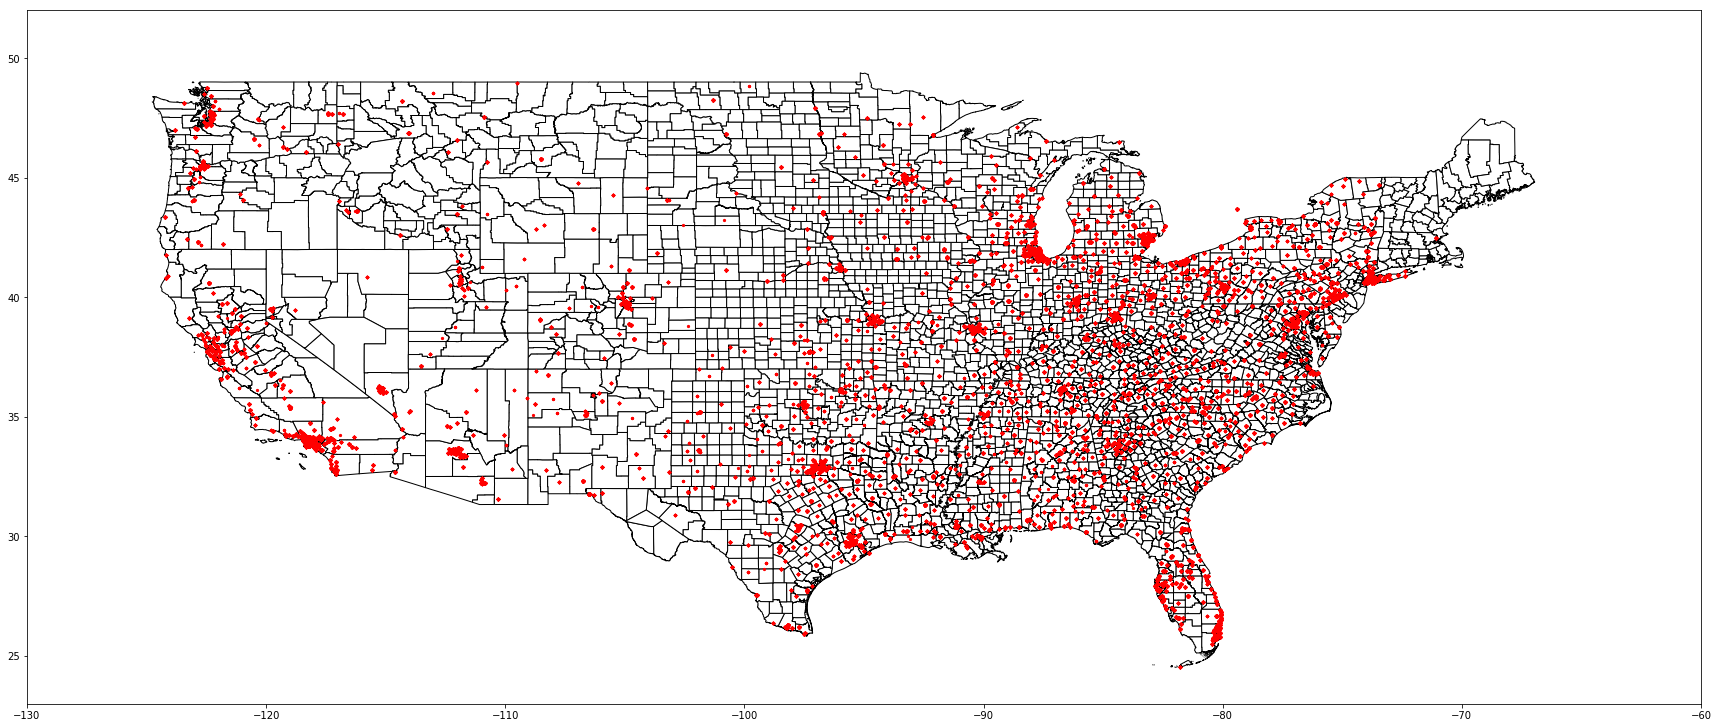

In [182]:
base = gdf_US.plot(color='white', edgecolor='black')
ax3 = gdf_medicare.plot(ax=base, marker='o', color='red', markersize=5)
ax3.set_xlim([-130, -60])
ax3.set_ylim([23, 52])
plt.rcParams["figure.figsize"] = [30,25]

In [ ]:
gdf_medicare.to_pickle('gdf_medicare')

In [ ]:
gdf_US.to_pickle('gdf_us')